# <center>N-BODY PROJECT    <center> Julia Lascar

### Question 1
Show that a single particle at rest remains motionless.

We use the technique of particle meshing to go faster. To do so we interpret Poisson's equation (second gradient of the potential is equal to 4piG times the density) and Newton's second law (F=ma) as a two dimensional (i,j) grid: 

In [66]:
from IPython.display import Latex
Latex(r"""\begin{equation}
\nabla ^2 \Phi (r_{i,j})= 4\pi G\rho(r_{i,j})
\\
F(r_{i,j})=-m \nabla \Phi (r_{i,j})
\end{equation}We will assume that the mass of each particle is 1, and that the gravitational constant is also 1 (for simplicity). 

We then solve Poisson's equation using Green's function. \begin{equation}
\Phi (r_{i,j})= \int \int g(r-r')\rho(r')d^2r' \\
\nabla^2 \Phi(r_{i,j}) = \nabla^2 \int \int g(r-r')\rho(r')d^2r' \\
\nabla^2 \Phi(r_{i,j}) = \int \int \nabla^2  g(r-r')\rho(r')d^2r'\\\end{equation}
And since we know that:
\begin{equation}
\nabla^2 \Phi(r_{i,j}) = 4\pi G \rho(r)\\\end{equation}
Then Green's function has:
\begin{equation}\nabla^2g=\delta \\\end{equation} 
Since:\begin{equation}
\nabla^2 \Phi(r_{i,j}) = \int \delta(r-r')\rho(r')d^2r' = \rho(r)\\
\end{equation}
Now we can use an Ansatz to solve Green's function.
\begin{equation}
g=\frac{1}{(2\pi)^2}\int\int \hat{g}(k)e^{ik\cdot r}d^2k\\
g=\frac{1}{(2\pi)^2}\int\int \hat{g}(k)e^{ik\cdot r}d^2k\\
\delta=\nabla^2 \frac{1}{(2\pi)^2}\int\int \hat{g}(k)e^{ik\cdot r}d^2k\\

\delta=\frac{1}{(2\pi)^2}\int\int \hat{g}(k)\nabla^2 (k)e^{ik\cdot r}d^2k\\

\delta=\frac{1}{(2\pi)^2}\int\int \hat{g}(k)(-k^2)e^{ik\cdot r}d^2k\\

\delta e^{-i(k'\cdot r)}=e^{-i(k'\cdot r)}\frac{1}{(2\pi)^2}\int\int \hat{g}(k)(-k^2)e^{ik\cdot r}d^2k\\

\delta e^{-i(k'\cdot x)}=\frac{1}{(2\pi)^2}\int\int \hat{g}(k)(-k^2)e^{i(k-k')\cdot r}d^2k\\

\int\int \delta e^{-i(k'\cdot x)}d^2r=\frac{1}{(2\pi)^2}\int\int \hat{g}(k)(-k^2)\int\int e^{i(k-k')\cdot r}d^2k d^2r\\

1=\int\int \hat{g}(k)(-k^2)\frac{1}{(2\pi)^2}\int\int e^{i(k-k')\cdot r}d^2k d^2r\\

1=\int\int \hat{g}(k)(-k^2)\delta(k-k')d^2k\\

1=-k^2\hat{g}(k)\\

\hat{g}(k)=-\frac{1}{k^2}\\
\end{equation} Which transforms to:
\begin{equation}
\hat{g}(x)=\frac{1}{4\pi x}\\
\end{equation}
So we can now solve poisson's equation using:
\begin{equation}
\Phi = \rho \otimes g
\end{equation}If we fast fourier transform, the convolution becomes a simple multiplication.
\begin{equation}\hat{\Phi} = \rho \hat{g}\end{equation}
We can inverse that back to get the potential. Taking the gradient of this then gives us our force. In code:
""")

<IPython.core.display.Latex object>

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import clear_output
import time
T=50
def NBody(N,X,Y,vx,vy,n,T=50,e=0.5,DT=0.5,speed=0.01):
    #N: number of bins
    #T: number of iterations
    #e: softening parameter 
    ax,ay=[],[]
    Ekin, Epot, Etot=[],[],[]
    rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
    X_C,Y_C=[],[] #center of each cell 
    for i in range(N): 
        X_C.append((edgex[i]+edgex[i+1])/2)
        Y_C.append((edgey[i]+edgey[i+1])/2)
    XX_C,YY_C=np.meshgrid(X_C,Y_C)
    G=1/(np.sqrt((XX_C-N/2)**2+(YY_C-N/2)**2+e**2)) #Green's function
    for t in range(T):
        clear_output(wait=True)
        rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
        rhoT=np.transpose(rho)
        #Take the FT of rho and G, multiply them
        Frho=np.fft.rfft2(rhoT)
        FG=np.fft.rfft2(G)
        GR=FG*Frho
        #Take the IFT to get phi
        phi=np.fft.fftshift(np.fft.irfft2(GR,rho.shape))
        if (N % 2) != 0:
            phi=np.roll(phi, 1, axis=(0,1))
        #Calculate gradient of phi, because m=1, result is F
        F=np.gradient(phi)
        Fx=F[1]
        Fy=F[0]
        #Because m=1, F is equal to acceleration
        #Calculate new velocity of the particle 
        dt=np.zeros(len(X))+DT
        #print("X",X,"Y",Y)
        #print(Fx.shape,Fy.shape)
        
        vxx=[]
        vyy=[]
        for i in range(n):
            if X[i]>N-1: #periodic boundary conditions
                X[i]=X[i]-N*abs((X[i]//N))
            elif X[i]<0:
                X[i]=X[i]+N*abs((X[i]//N))
                
            if Y[i]>N-1 :
                Y[i]=Y[i]-N*abs((Y[i]//N))
            elif Y[i]<0:
                Y[i]=Y[i]+N*abs((Y[i]//N))
                
            x=np.int_(X[i])
            y=np.int_(Y[i])
            
            #print("force x",Fx[x,y],"force y",Fy[x,y])
            vx[i]-=Fx[x,y]*DT
            vxx.append((vx[i])**2)
            vy[i]-=Fy[x,y]*DT
            vyy.append((vy[i])**2)
            X[i]+=vx[i]*DT
            Y[i]+=vy[i]*DT
            #print("v",vx,vy,"v1",vx1,vy1)
            
            #print("x",x,"y",y)
            #print("X",X[i],"Y",Y[i])
            
           
        #print(X1)
        #print(Y1)
        
        #Update all positions and repeat
        fig = plt.figure(figsize=(10, 9))
        plt.pcolormesh(Fy)
        plt.colorbar()
        #plt.xticks(edgex)
        #plt.yticks(edgey)
        plt.grid()
        plt.scatter(X,Y,s=2, c='w')
        #plt.xticks(edgex)
        #plt.yticks(edgey)
        plt.ylim(0,N)
        plt.xlim(0,N)
        plt.show()
        print("t=",t)
        time.sleep(speed)
        #print("X",X,"Y",Y)
        #print("v",vx,vy)
        
        ek = 0.5*np.sum(vxx+vyy)
        ep = 0.5*np.sum(phi)
        et = ek+ep
        
        Ekin.append(ek)
        Epot.append(ep)
        Etot.append(et)
        #print("t=",t,"E=",et)
        
    return rho,Etot



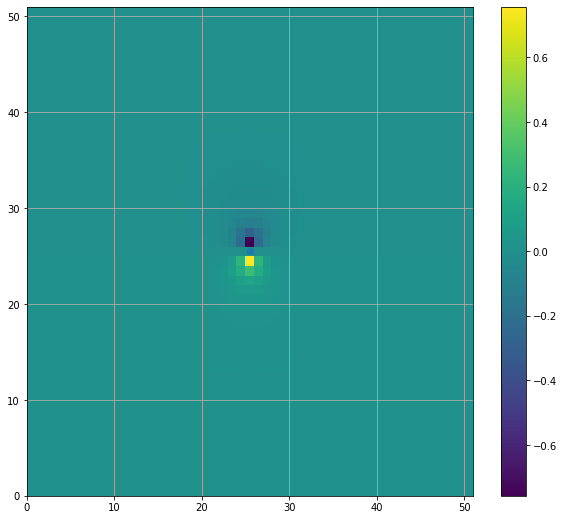

t= 49


In [20]:
N=51
n=2
X1=np.asarray([N/2])
Y1=np.asarray([N/2])
#X1=np.random.uniform(0,N,n)
#Y1=np.random.uniform(0,N,n)

vx1=np.zeros(len(X1))
vy1=np.zeros(len(Y1))
rho,Etot=NBody(N,X1,Y1,vx1,vy1,1)

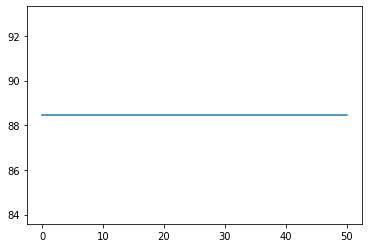

In [10]:
Time=np.linspace(0,T)
plt.plot(Time,Etot)

Energy is conserved.

### Question 2
Show that a pair of particles placed in a circular orbit continue to orbit each other, for at least some reasonable length of time.

To get an orbit, we set the original boundary conditions using the centripetal force equation, we get a velocity that is tagential to the motion and of magnitude v: 

In [23]:
from IPython.display import Latex
Latex(r"""\begin{equation}F=\frac{mv^2}{r}=\frac{GMm}{r^2}\\
v^2=\frac{GM}{r}\\
v=\sqrt{\frac{GM}{r}\\}
\end{equation}
""")

<IPython.core.display.Latex object>

We pick two points alligned on the x axis separated by a distance of R. The circular velocity should thus be in the y direction:

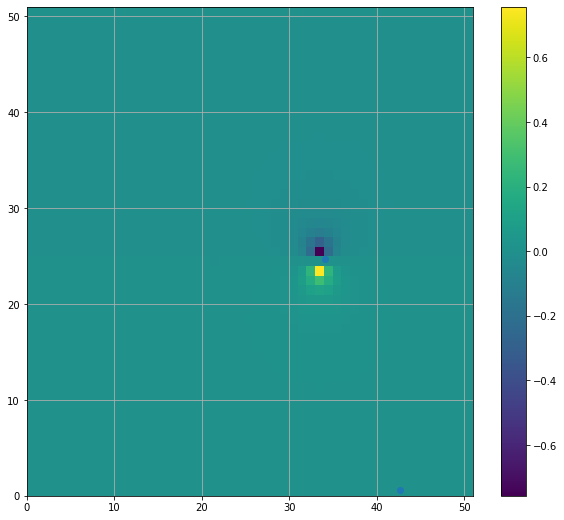

t= 49


In [26]:
T=50
R=3
N=51
x1=N/2+R/2
x2=N/2-R/2
y1=N/2
y2=N/2
v1=np.sqrt(1/R) #GM=1
X=[x1,x2]
Y=[y1,y2]
vx1=[0,0]
vy1=[-v1,v1]
rho,ETot=NBody(N,X,Y,vx1,vy1,2,T=T,speed=0.001)

There must be a bug somewhere that I couldn't find despite much searching...

### Question 3
Set up both periodic and non-periodic boundary conditions. Set up a problem where hundreds of thousands of particles are initially scattered randomly throughout the domain. Show the evolution with time for both periodic and non-periodic boundary conditions. Track the total energy - how well is it conserved?

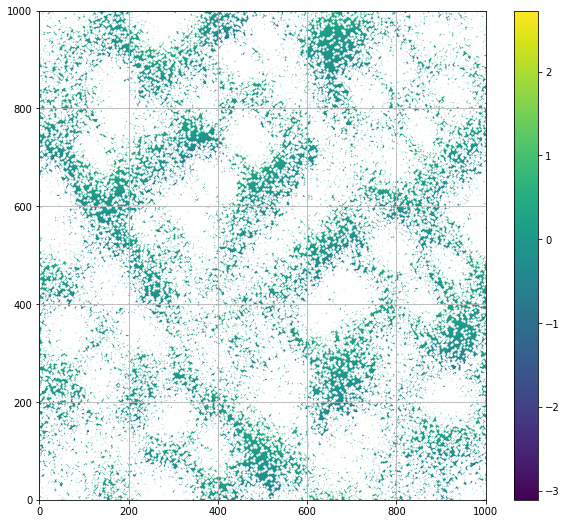

t= 99


In [7]:
#random distribution
N=1000
n=100000
X1=np.random.uniform(0,N,n)
Y1=np.random.uniform(0,N,n)
vx1=np.random.uniform(-1,1,n)
vy1=np.random.uniform(-1,1,n)

rho,E=NBody(N,X1,Y1,vx1,vy1,n,T=100)

We observe that the particles cluster into progressively denser clumps, as one might expect. 

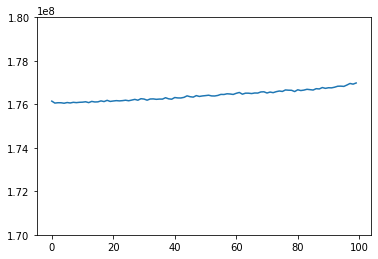

In [9]:
plt.plot(E)
plt.ylim(1.7e8,1.8e8)
plt.show()

As we can see, energy is overall rather well conserved.

In [2]:

def NBody_nonperiodic(N,X,Y,vx,vy,n,T=50,e=0.5,DT=0.5,speed=0.01):
    #N: number of bins
    #T: number of iterations
    #e: softening parameter
    ax,ay=[],[]
    Ekin, Epot, Etot=[],[],[]
     #pad for non-periodic conditions 
    rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
    X_C,Y_C=[],[] #center of each cell 
    for i in range(N): 
        X_C.append((edgex[i]+edgex[i+1])/2)
        Y_C.append((edgey[i]+edgey[i+1])/2)
    XX_C,YY_C=np.meshgrid(X_C,Y_C)
    G=1/(np.sqrt((XX_C-N/2)**2+(YY_C-N/2)**2+e**2)) #Green's function
    for t in range(T):
        clear_output(wait=True)
        rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
        rhoT=np.transpose(rho)
        #Take the FT of rho and G, multiply them
        Frho=np.fft.rfft2(rhoT)
        FG=np.fft.rfft2(G)
        GR=FG*Frho
        #Take the IFT to get phi
        phi=np.fft.fftshift(np.fft.irfft2(GR,rhoT.shape))
        if (N % 2) != 0:
            phi=np.roll(phi, 1, axis=(0,1))
        #Calculate gradient of phi, because m=1, result is F
        F=np.gradient(phi)
        Fx=F[1]
        Fy=F[0]
        P=20*N # padding
        Fx=np.pad(Fx, P, mode='constant')
        Fy=np.pad(Fy, P, mode='constant')
        #Because m=1, F is equal to acceleration
        #Calculate new velocity of the particle 
        vxx=[]
        vyy=[]
        
        for i in range(n):
            x=int(round(X[i]))+P
            y=int(round(Y[i]))+P
            vx[i]-=Fx[x,y]*DT
            vy[i]-=Fy[x,y]*DT
            X[i]+=vx[i]*DT
            Y[i]+=vy[i]*DT
            
            #vyy.append((vy[i]-Fy[x,y]*DT)**2)
            #print("v",vx,vy,"v1",vx1,vy1)
            
            #print("x",x,"y",y)
            #print("X",X[i],"Y",Y[i])
            
           
        #print(X1)
        #print(Y1)
        
        #Update all positions and repeat
        fig = plt.figure(figsize=(10, 9))
        plt.xlim(P,N+P)
        plt.ylim(P,N+P)
        plt.pcolormesh(Fy)
        #plt.colorbar()
        #plt.xticks(edgex)
        #plt.yticks(edgey)
        #plt.grid()
        plt.scatter(X+P,Y+P,s=2, c='w')
        #plt.xticks(edgex)
        #plt.yticks(edgey)
        plt.show()
        print("t=",t)
        time.sleep(speed)
        #print("X",X,"Y",Y)
        #print("v",vx,vy)
        
        ek = 0.5*np.sum(vxx+vyy)
        ep = 0.5*np.sum(phi)
        et = ek+ep
        
        Ekin.append(ek)
        Epot.append(ep)
        Etot.append(et)
        #print("t=",t,"E=",et)
        
    return rho,Etot




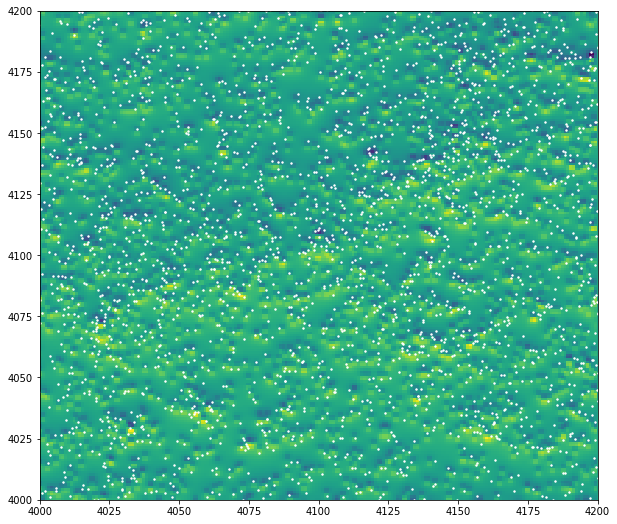

t= 49


In [5]:
N=200
n=100000
X1=np.random.uniform(0,N,n)
Y1=np.random.uniform(0,N,n)
vx1=np.random.uniform(-1,1,n)
vy1=np.random.uniform(-1,1,n)

rho,Ep=NBody_nonperiodic(N,X1,Y1,vx1,vy1,n)

We see that with the non-periodic boundary conditions, the result is not very realistic (not as much clustering)

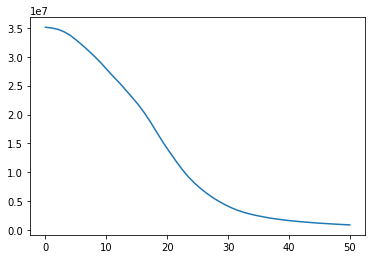

In [10]:
t=np.linspace(0,50)
plt.plot(t,Ep)
plt.show()

## Question 4
In cosmology, we start the universe with a scale-invariant power spectrum, so mass fluctuations are proportional to k−3. Start with the particles on a grid, but with masses derived from a realization of k−3 and use periodic boundary conditions. How does your universe look now?

In [50]:
from IPython.display import Latex
Latex(r"""Recalling that:
\begin{equation}\hat{\Phi} = \rho \hat{g}\\
\hat{g}(k)=-\frac{1}{k^2}\\
\end{equation}
We can get: 
\begin{equation}
\rho + \delta \rho= \rho + \beta k^{-3} \\
\hat{\Phi}\hat{g}^{-1}(k) = (\rho + \beta k^{-3})\\
\rho= \hat{\Phi}\hat{g}^{-1}(k)- \beta k^{-3}
\end{equation}
Where we make beta vary to express fluctuations. From Green's function: 
\begin{equation}
\hat{g}(k)=-k^{-2}\\
\hat{g}(k)^{1/2}=-k^{-1}\\
\beta k^{-3} = -\beta \hat{g}(k)^{3/2}\\
\rho(k)= \hat{\Phi}\hat{g}^{-1}(k)-\beta \hat{g}(k)^{3/2}\\
\hat{\Phi}\hat{g}^{-1}(k)=\rho(k)+\beta \hat{g}(k)^{3/2} \\
\hat{\Phi}=\rho(k)\hat{g}(k)+\beta \hat{g}(k)^{5/2} \\
\Phi=IF(\rho(k)\hat{g}(k)+\beta \hat{g}(k)^{5/2})
\end{equation}
""")

<IPython.core.display.Latex object>

In [62]:
N=1000
n=100
X1=np.random.uniform(0,N,n)
Y1=np.random.uniform(0,N,n)
vx1=np.random.uniform(-1,1,n)
vy1=np.random.uniform(-1,1,n)
T=50
e=0.5
DT=0.5
speed=0.01

X_C,Y_C=[],[] #center of each cell 
rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
for i in range(N): 
    X_C.append((edgex[i]+edgex[i+1])/2)
    Y_C.append((edgey[i]+edgey[i+1])/2)
XX_C,YY_C=np.meshgrid(X_C,Y_C)
G=1/(np.sqrt((XX_C-N/2)**2+(YY_C-N/2)**2+e**2)) #Green's function
Beta=np.random.uniform(0,1,N)
    
g=np.sqrt(G)
gg=g*G*G
GB=Beta*gg
FGB=np.fft.rfft2(GB)
print("GB",np.shape(GB))
print("FGB",np.shape(FGB))
rhoT=np.transpose(rho)
print("rhoT",np.shape(rhoT))
Frho=np.fft.rfft2(rhoT)
print("Frho",np.shape(Frho))
FG=np.fft.rfft2(G)
print("FG",np.shape(FG))
GR=FG*Frho
print("GR",np.shape(GR))

GB (1000, 1000)
FGB (1000, 501)
rhoT (1000, 1000)
Frho (1000, 501)
FG (1000, 501)
GR (1000, 501)


In [63]:

def NBody_k3(N,X,Y,vx,vy,n,T=50,e=0.5,DT=0.5,speed=0.01):
    #N: number of bins
    #T: number of iterations
    #e: softening parameter 
    ax,ay=[],[]
    Ekin, Epot, Etot=[],[],[]
    rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
    X_C,Y_C=[],[] #center of each cell 
    for i in range(N): 
        X_C.append((edgex[i]+edgex[i+1])/2)
        Y_C.append((edgey[i]+edgey[i+1])/2)
    XX_C,YY_C=np.meshgrid(X_C,Y_C)
    G=1/(np.sqrt((XX_C-N/2)**2+(YY_C-N/2)**2+e**2)) #Green's function
    Beta=np.random.uniform(0,1,N)
    
    g=np.sqrt(G)
    gg=g*G*G
    GB=Beta*gg
    FGB=np.fft.rfft2(GB)
    for t in range(T):
        clear_output(wait=True)
        rho,edgex,edgey=np.histogram2d(X,Y,bins=N,range=[[0,N],[0,N]])
        rhoT=np.transpose(rho)
        #Take the FT of rho and G, multiply them
        Frho=np.fft.rfft2(rhoT)
        FG=np.fft.rfft2(G)
        GR=FG*Frho
        GRRB=GR+FGB
        #Take the IFT to get phi
        phi=np.fft.fftshift(np.fft.irfft2(GRRB,rho.shape))
        if (N % 2) != 0:
            phi=np.roll(phi, 1, axis=(0,1))
        #Calculate gradient of phi, because m=1, result is F
        F=np.gradient(phi)
        Fx=F[1]
        Fy=F[0]
        #Because m=1, F is equal to acceleration
        #Calculate new velocity of the particle 
        dt=np.zeros(len(X))+DT
        #print("X",X,"Y",Y)
        #print(Fx.shape,Fy.shape)
        
        vxx=[]
        vyy=[]
        for i in range(n):
            if X[i]>N-1: #periodic boundary conditions
                X[i]=X[i]-N*abs((X[i]//N))
            elif X[i]<0:
                X[i]=X[i]+N*abs((X[i]//N))
                
            if Y[i]>N-1 :
                Y[i]=Y[i]-N*abs((Y[i]//N))
            elif Y[i]<0:
                Y[i]=Y[i]+N*abs((Y[i]//N))
                
            x=np.int_(X[i])
            y=np.int_(Y[i])
            
            #print("force x",Fx[x,y],"force y",Fy[x,y])
            vx[i]-=Fx[x,y]*DT
            vxx.append((vx[i])**2)
            vy[i]-=Fy[x,y]*DT
            vyy.append((vy[i])**2)
            X[i]+=vx[i]*DT
            Y[i]+=vy[i]*DT
            #print("v",vx,vy,"v1",vx1,vy1)
            
            #print("x",x,"y",y)
            #print("X",X[i],"Y",Y[i])
            
           
        #print(X1)
        #print(Y1)
        
        #Update all positions and repeat
        fig = plt.figure(figsize=(10, 9))
        plt.pcolormesh(Fy)
        plt.colorbar()
        #plt.xticks(edgex)
        #plt.yticks(edgey)
        plt.grid()
        plt.scatter(X,Y,s=2, c='w')
        #plt.xticks(edgex)
        #plt.yticks(edgey)
        plt.ylim(0,N)
        plt.xlim(0,N)
        plt.show()
        print("t=",t)
        time.sleep(speed)
        #print("X",X,"Y",Y)
        #print("v",vx,vy)
        
        ek = 0.5*np.sum(vxx+vyy)
        ep = 0.5*np.sum(phi)
        et = ek+ep
        
        Ekin.append(ek)
        Epot.append(ep)
        Etot.append(et)
        #print("t=",t,"E=",et)
        
    return rho,Etot



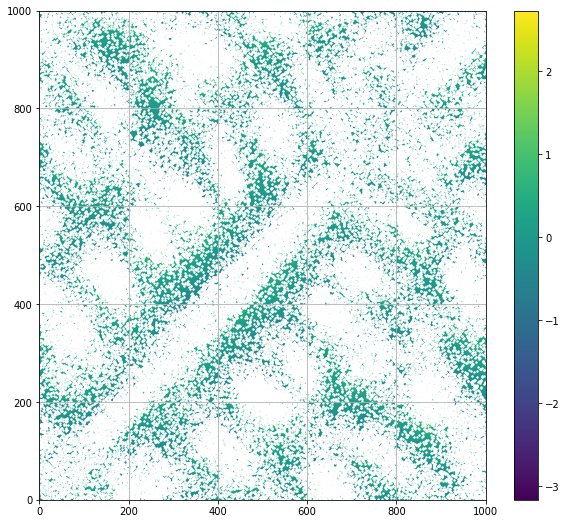

t= 99


In [67]:
N=1000
n=100000
X1=np.random.uniform(0,N,n)
Y1=np.random.uniform(0,N,n)
vx1=np.random.uniform(-1,1,n)
vy1=np.random.uniform(-1,1,n)

rhok,Ek=NBody_k3(N,X1,Y1,vx1,vy1,n,T=100)